## Lab 1 - Examining the performance benefits of the Cachetools library

### Setup

Below are the imports needed for Lab 1 - Cachetools and have been included in the instantiation of the conda environment.  

In [ ]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf, avg, col,lit,call_udf,min,call_builtin,call_function,call_udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType
import pandas as pd
import numpy as np
import json

Next, import snowpark and verify by printing the version.

In [ ]:
from snowflake.snowpark import version
print(version.VERSION)

Connect to Snowflake by opening the `credentials.json` file and creating a session.

In [ ]:
with open('credentials.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()

print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())


Confirm that the the output of the print statement is the following: `[Row(CURRENT_WAREHOUSE()='CLUSTER1', CURRENT_DATABASE()='SNOWPARK_BEST_PRACTICES', CURRENT_SCHEMA()='PUBLIC')]`



### Create the Pickle File
Run the following code to build the sample pickle file.

In [ ]:
import pickle

day_dict = {1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday', 7: 'sunday'}
print(day_dict)

with open('alldays.pkl', 'wb') as file:
    pickle.dump(day_dict, file) 

Next, let's test the pickle file output.

In [ ]:
# Sample function to test loading pickle file
def getname():
    with open('alldays.pkl','rb') as fileopen:
        f1=pickle.load(fileopen)               
    return f1

def getday(key):
    dict1=getname()
    return dict1[key]

r=getday(3)
print(r)

### Creating named Stage and Uploading the Pickle File

Next, we will create a stage in Snowflake to upload the pickle file to.

In [ ]:
session.sql("create or replace stage pythonstage").collect()
session.file.put("alldays.pkl", "pythonstage", auto_compress=False,overwrite=True)
session.sql("ls @pythonstage").collect()

With the pickle file successfully loaded, we are now ready to A/B test our UDF with and without Cachetools in the next steps.

### Creating Python UDF Without Cachetools

The block of code below creates a Python UDF without any use of the Cachetools library.

In [ ]:
import sys
import os
import cachetools
from snowflake.snowpark.types import StringType,IntegerType

'''
We are importing the Pickle file in the session.

extract_name() -> deserializes the dictionary from the pickle and returns a dictionary object to the caller

getvalue() -> Takes a day number and return the name.

'''
session.add_import("@pythonstage/alldays.pkl")
def extract_name()->dict:
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    file_path = import_dir + "alldays.pkl"
    
    with open(file_path,'rb') as file:
        dict1=pickle.load(file)

    return dict1

def getvalue(key:int)->str:   
    filedict= extract_name()
    return filedict[key]
    
# Creating a Python UDF
udf_nocache = session.udf.register(
    func=getvalue,
    name="udf_nocachetools",
    stage_location='pythonstage',
    is_permanent=True,
    replace=True, 
    input_types=[IntegerType()],
    return_type=StringType()
)

### Creating Sample data
Next, we will create 2 million rows of sample data for the UDF to run against.

In [ ]:
arr_random = np.random.randint(low=1, high=7, size=(2000000,3))
df = pd.DataFrame(arr_random, columns=['invoice_num','trx_num','weekday'])

df_transactions=session.createDataFrame(df,schema=['invoice_num','trx_num','weekday'])

df_transactions.count() # 2 Million records

### Call the UDF
Let's call the UDF and create a new table from the resultset with the below code.

In [ ]:
from datetime import datetime

st=datetime.now()
df_transactions.withColumn('weekdayname',call_udf('udf_nocachetools',df_transactions['"weekday"'].astype('int')))\
.write.mode('overwrite').save_as_table("NoCacheTransactionTable")
et=datetime.now()
print(f"Total duration without using Cachetools library ={(et-st).total_seconds()}")

Note your runtime. It will likely be between 130-160 seconds. For the first run you will likely see better performance, but when you execute it multiple times, you will start seeing query taking more time to complete.

### Analyze performance with the Query Profiler
Let's take a look at the query profile in Snowflake to understand where the time is spent.  Login to Snowsight and navigate to [Query History](https://docs.snowflake.com/en/user-guide/ui-snowsight-activity#label-snowsight-activity-query-history) and click on the query profile for the last query ran.  Observate that total Python UDF handler execution time is 130 seconds. This is due to for every record the UDF invocation is reading the file from disk.  Your query profile should look like the image below.

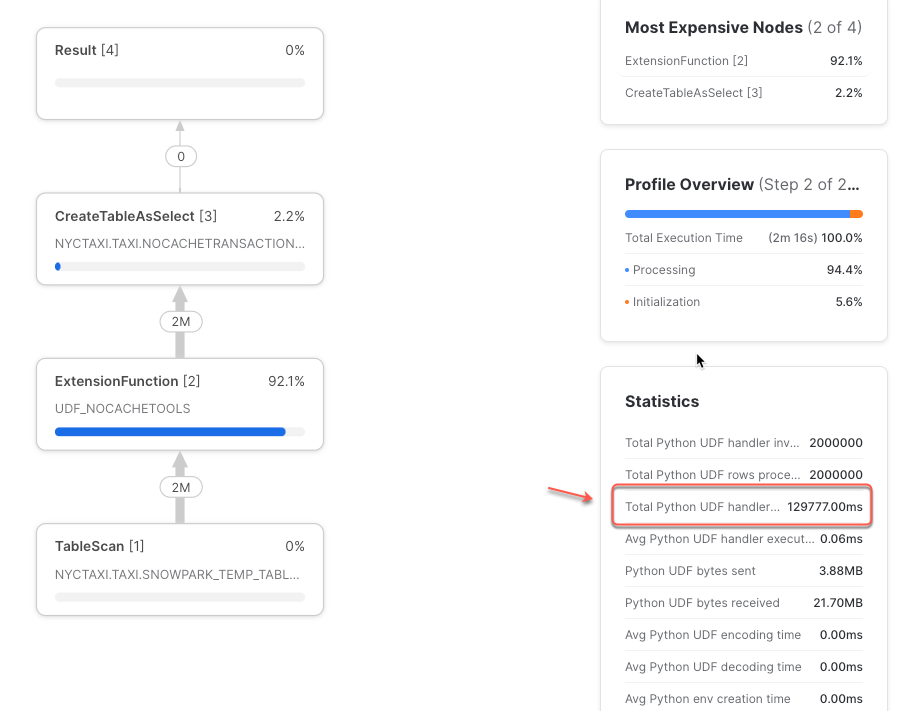



Lastly, confirm that the UDF ran and successfully created a new table as expected by running the following:


In [ ]:
session.sql("select * from NoCacheTransactionTable limit 10").show()

### Creating Python User Defined Function With Cachetools

In the below cell, we will leverage the [Cachetools](https://pypi.org/project/cachetools/) library which will read the pickle file once and cache it.

In [ ]:
import sys
import os
import cachetools
from snowflake.snowpark.types import StringType
import zipfile

'''
Using cachetools decorator while creating the function extract_name. Using this decorator the file will be read once and then cached. 
Other UDF execution will use the cached file and avoids reading the file from the storage.
'''

session.add_import("@pythonstage/alldays.pkl")

@cachetools.cached(cache={})
def extract_name()->dict:
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    file_path = import_dir + "alldays.pkl"
    
    with open(file_path,'rb') as file:
        dict1=pickle.load(file)

    return dict1


def getvalue(key:int)->str:   
    filedict= extract_name()
    return filedict[key]
    

session.add_packages("cachetools")
udf_cache = session.udf.register(
    func=getvalue,
    name="udf_withcachetools",
    stage_location='pythonstage',
    is_permanent=True, 
    replace=True, 
    input_types=[IntegerType()],
    return_type=StringType()
)

### Creating Sample data

Just like in the previous test, we will create 2 million rows of sample data for the UDF to run against.

In [ ]:
arr_random = np.random.randint(low=1, high=7, size=(2000000,3))
df = pd.DataFrame(arr_random, columns=['invoice_num','trx_num','weekday'])

df_transactions=session.createDataFrame(df,schema=['invoice_num','trx_num','weekday'])

df_transactions.count() # 2 Million records

### Call the UDF

Let's call the UDF and create a new table from the resultset with the below code.

In [ ]:
from datetime import datetime

st=datetime.now()
df_transactions.withColumn('"weekdayname"',call_udf('udf_withcachetools',df_transactions['"weekday"'].astype('int')))\
.write.mode('overwrite').save_as_table("CacheToolsTransactionTable")
et=datetime.now()
print(f"Total duration ={(et-st).total_seconds()}")

Note the runtime - it should be around 8-9 seconds, even if you rerun it multiple times.

### Analyze performance with the Query Profiler

Lets look at the query profile to understand where the time is spent. As you can see clearly from the below screenshot that the Total Python UDF handler execution time is only 4 seconds seconds as the UDF invocation is reading the the pickle content from the dictionary. Your query profile should look like the image below.

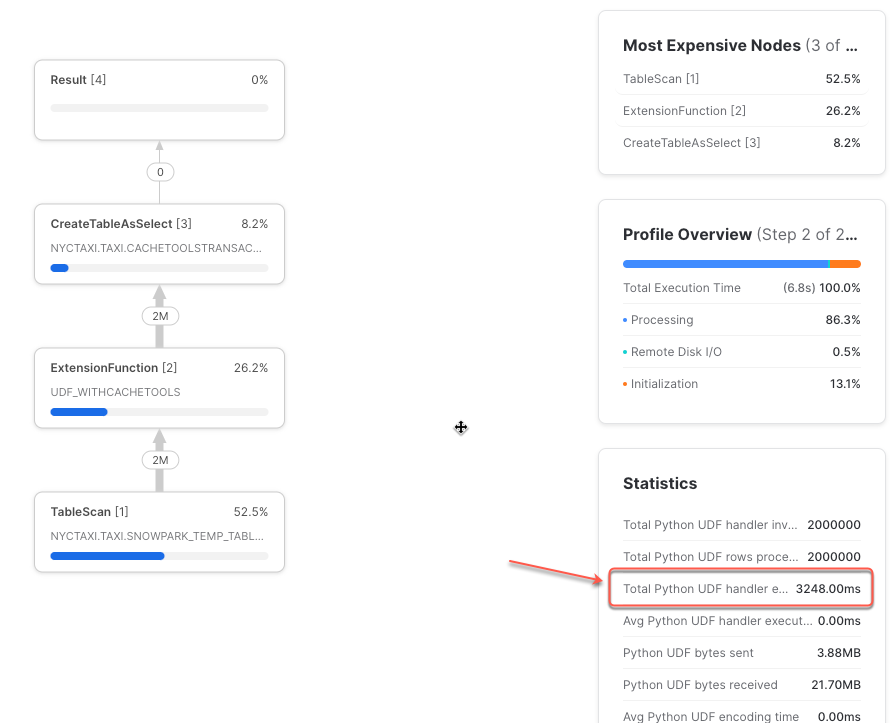



### Cleanup

Delete the dataframe and drop the tables created by the UDF executions in the A/B testing steps.  Finally, close the session.

In [ ]:
# Deleting the dataframe
del df_transactions

# Dropping the table
session.sql("drop table CacheToolsTransactionTable").collect()
session.sql("drop table NoCacheTransactionTable").collect()

# Closing the session
if session: 
    session.close()